In [4]:
import numpy as np
import pandas as pd
import pickle
import os
import shutil

import tensorflow.keras as keras

import matplotlib.pyplot as plt
import seaborn as sns

import datasets
import eval_methods
import sklearn_models
import pyspark_models

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

seed=0

from pyspark import SparkContext
try:
    sc = SparkContext().getOrCreate()
except:
    pass

2022-11-04 13:30:16.146938: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-04 13:30:16.146956: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
x_train, x_test, y_train, y_test = datasets.get_sklearn_diabetes()
train, test = datasets.get_pyspark_diabetes(sc)

In [6]:
sklearn_classifiers = [
    sklearn_models.LinearSVC(random_state=seed),
    sklearn_models.LogisticRegression(random_state=seed),
    sklearn_models.DecisionTreeClassifier(random_state=seed),
    sklearn_models.RandomForestClassifier(random_state=seed),
    sklearn_models.GaussianNB(),
    sklearn_models.GradientBoostingClassifier(random_state=seed),
    sklearn_models.MLPClassifier(random_state=seed),
    sklearn_models.OneVsRestClassifier(sklearn_models.LinearSVC())
]
pyspark_classifiers = [
    pyspark_models.LinearSVC(labelCol="label"),
    pyspark_models.LogisticRegression(labelCol="label"),
    pyspark_models.DecisionTreeClassifier(labelCol="label", seed=seed),
    pyspark_models.RandomForestClassifier(labelCol = 'label', seed=seed),
    pyspark_models.NaiveBayes(labelCol = 'label', modelType="gaussian"),
    pyspark_models.GBTClassifier(labelCol = 'label', seed=seed),
    pyspark_models.MultilayerPerceptronClassifier(labelCol = 'label', seed=seed, layers=[len(test.toPandas()["features"][0]),100,]),
    pyspark_models.OneVsRest(labelCol = 'label', classifier=pyspark_models.LinearSVC())
]

2022-11-04 13:30:33.691328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 13:30:33.692065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-04 13:30:33.692138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-04 13:30:33.692202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-04 13:30:33.692265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

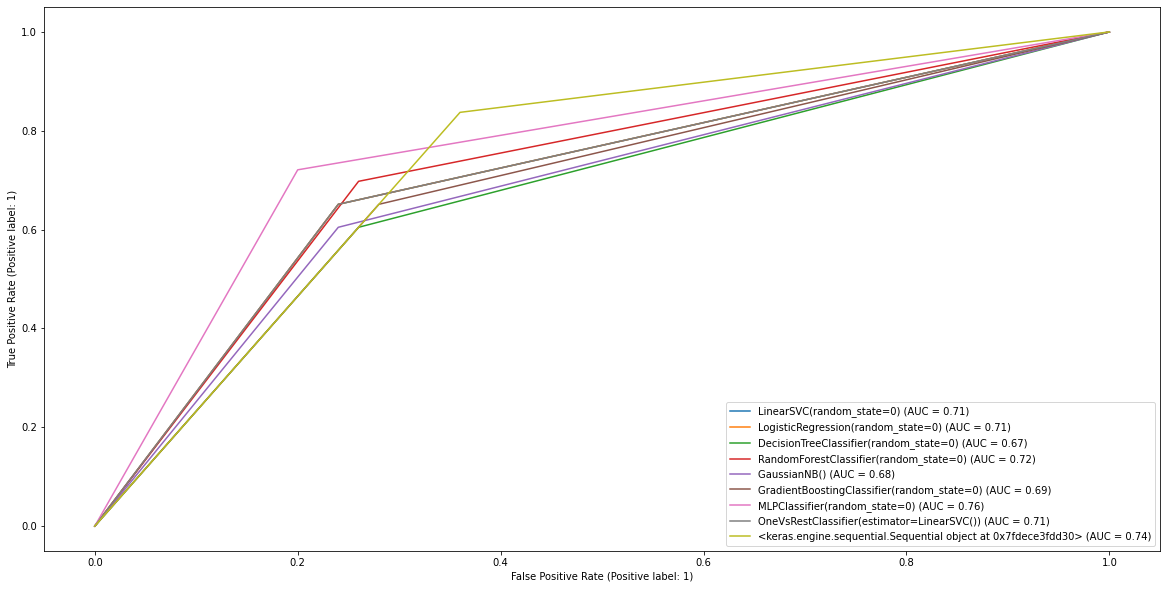

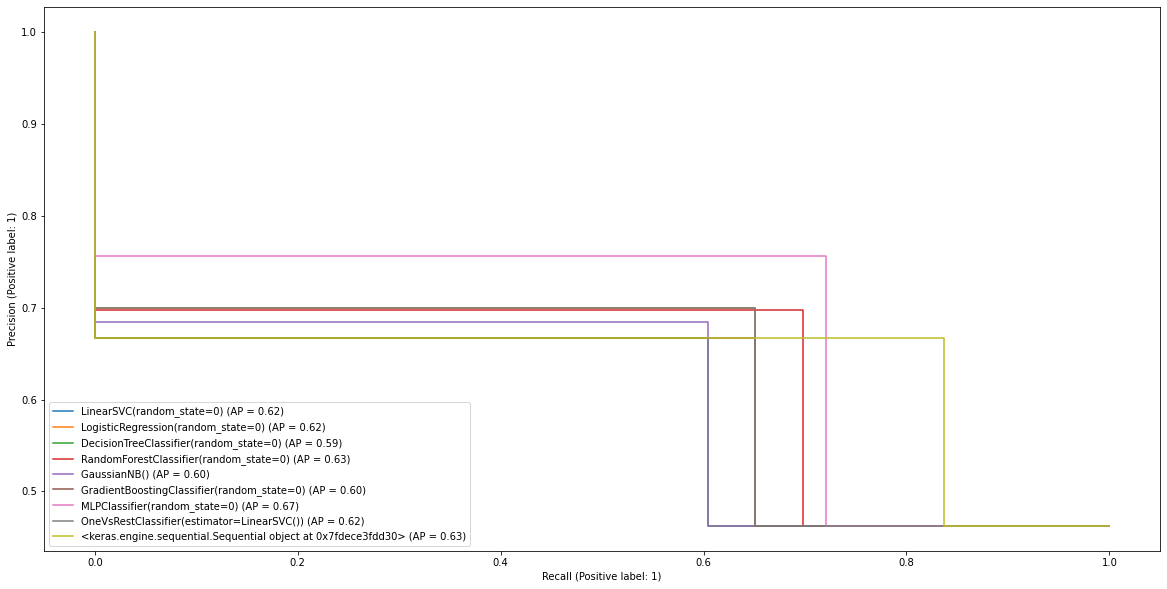

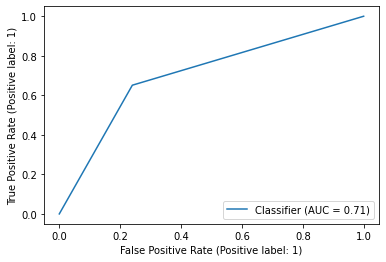

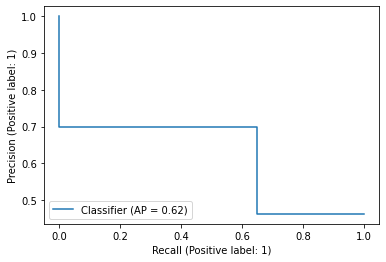

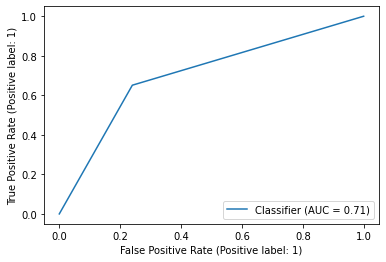

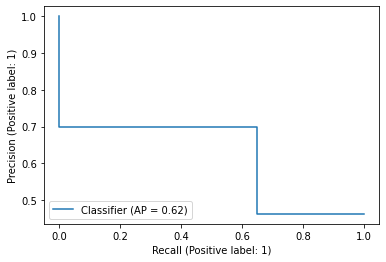

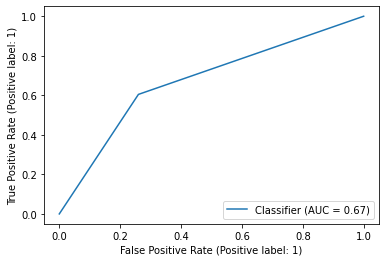

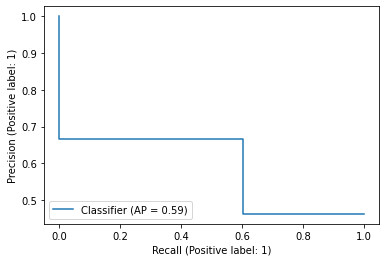

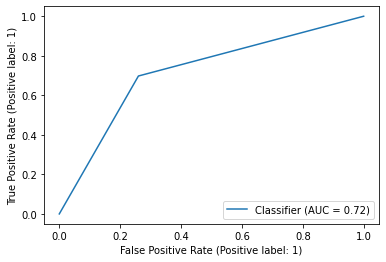

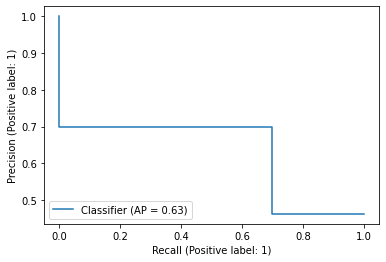

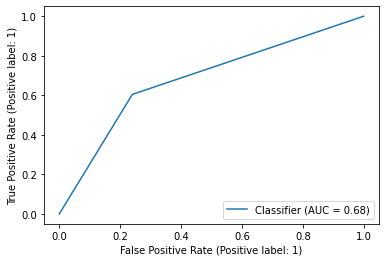

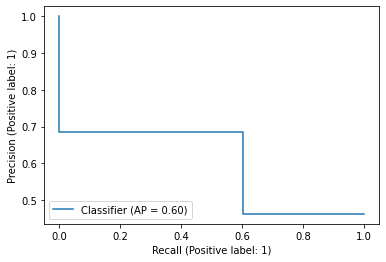

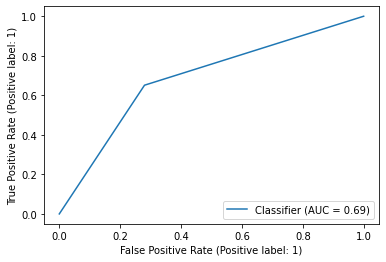

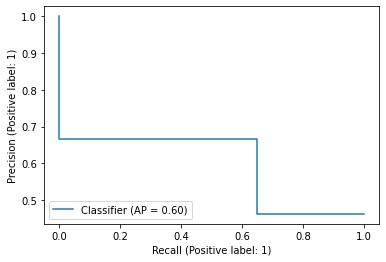

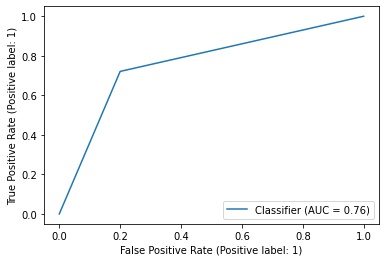

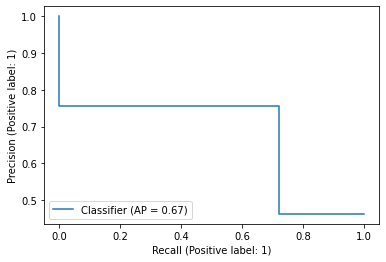

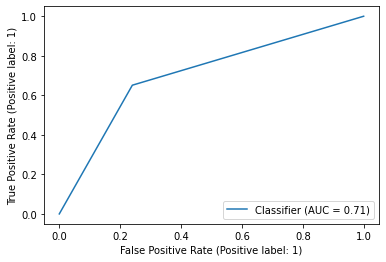

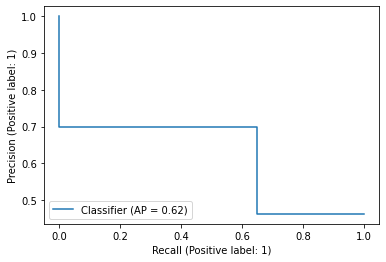

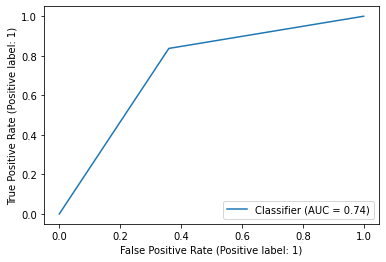

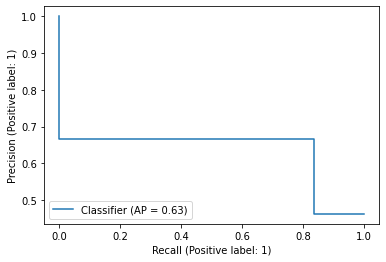

In [7]:
sklearn_accuracy = []
sklearn_confusion = []
sklearn_roc = []
sklearn_precision = []
sklearn_recall = []
_, ax = plt.subplots(figsize=(20, 10))
_, bx = plt.subplots(figsize=(20, 10))
for clf in sklearn_classifiers:
    clf.fit(x_train, y_train)
    accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, clf.predict(x_test), ax, bx)
    sklearn_accuracy.append(accuracy)
    sklearn_confusion.append(confusion)
    sklearn_roc.append(roc)
    sklearn_precision.append(precision)
    sklearn_recall.append(recall)


clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(1, activation='sigmoid'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=keras.metrics.BinaryAccuracy())

clf.fit(x_train, y_train, verbose=0)
accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, np.round(clf.predict(x_test, verbose=0))[:,0], ax, bx)
sklearn_accuracy.append(accuracy)
sklearn_confusion.append(confusion)
sklearn_roc.append(roc)
sklearn_precision.append(precision)
sklearn_recall.append(recall)

In [ ]:
pyspark_accuracy = []
pyspark_confusion = []
pyspark_roc = []
pyspark_precision = []
pyspark_recall = []
_, ax = plt.subplots(figsize=(20, 10))
_, bx = plt.subplots(figsize=(20, 10))
for clf in pyspark_classifiers:
    clf = clf.fit(train)
    real = np.array([1 if "1" in str(x) else 0 for x in clf.transform(test).select("label").collect()])
    pred = np.array([1 if "1" in str(x) else 0 for x in clf.transform(test).select("prediction").collect()])
    accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, real, pred, ax, bx)
    pyspark_accuracy.append(accuracy)
    pyspark_confusion.append(confusion)
    pyspark_roc.append(roc)
    pyspark_precision.append(precision)
    pyspark_recall.append(recall)
    
clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(1, activation='sigmoid'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=keras.metrics.BinaryAccuracy())

clf.fit(x_train, y_train, verbose=0)
accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, np.round(clf.predict(x_test, verbose=0))[:,0], ax, bx)
pyspark_accuracy.append(accuracy)
pyspark_confusion.append(confusion)
pyspark_roc.append(roc)
pyspark_precision.append(precision)
pyspark_recall.append(recall)

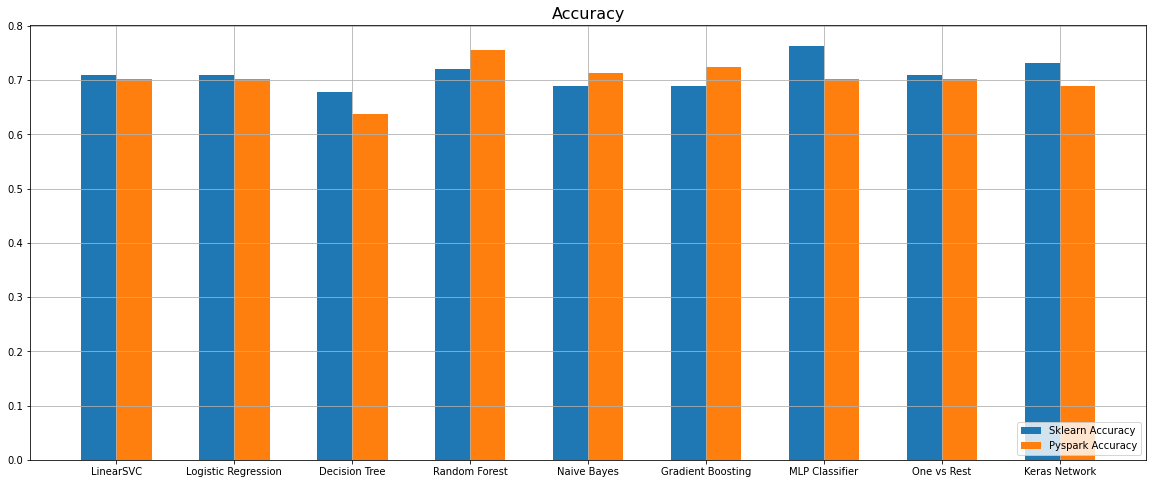

In [9]:
eval_methods.plot(sklearn_accuracy, pyspark_accuracy, "Accuracy")

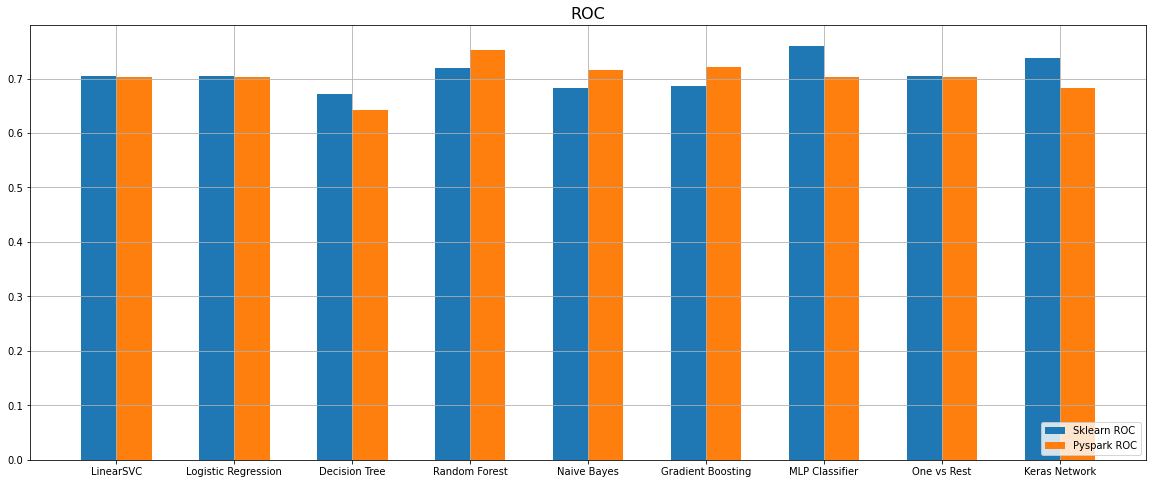

In [10]:
eval_methods.plot(sklearn_roc, pyspark_roc, "ROC")

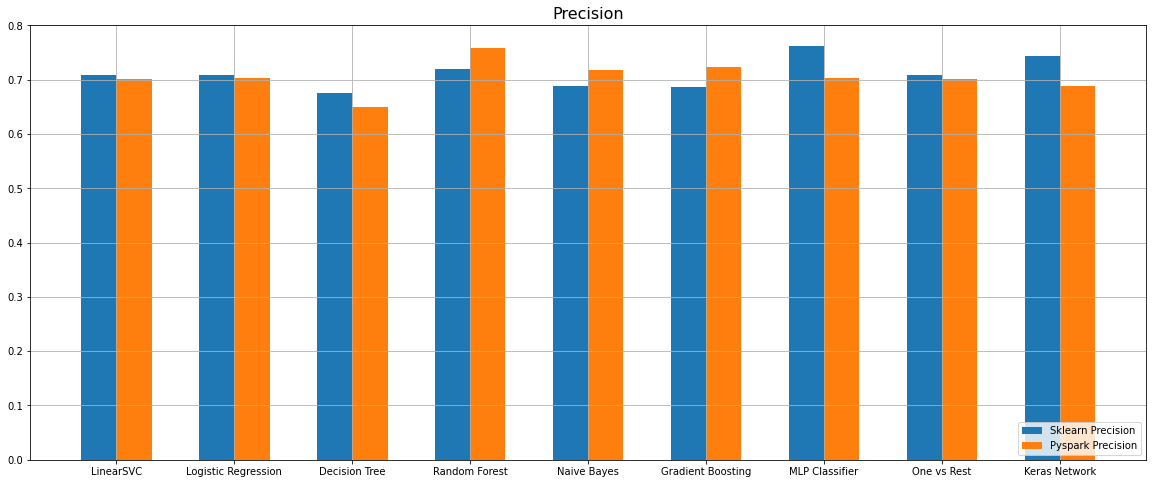

In [11]:
eval_methods.plot(sklearn_precision, pyspark_precision, "Precision")

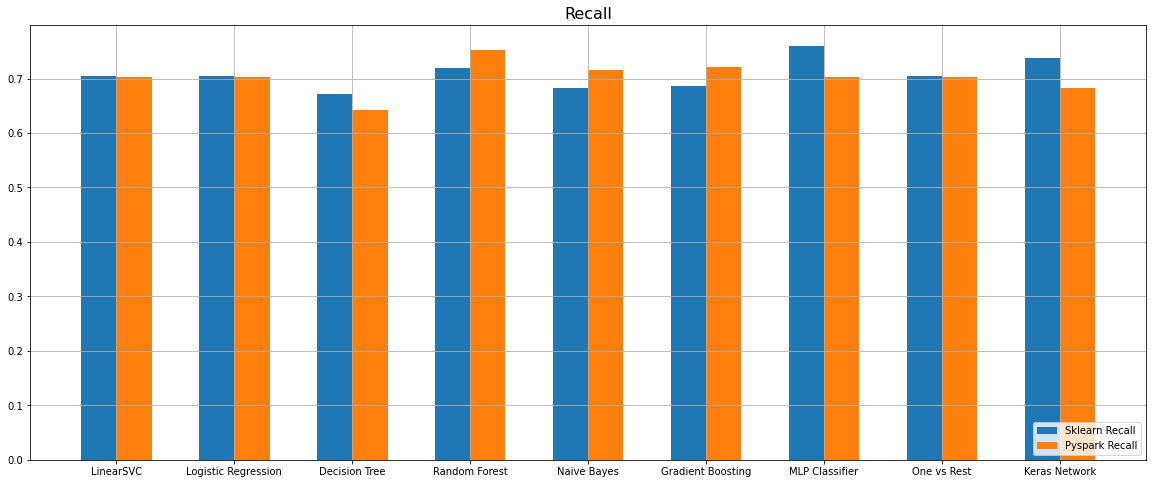

In [12]:
eval_methods.plot(sklearn_recall, pyspark_recall, "Recall")

In [13]:
grid = { 
    "LinearSVC": {
        "max_iter": [10, 50, 100, 500],
        "tol": [1e-2, 1e-3, 1e-4, 1e-5],
        "C": [0.1, 0.01, 0.001, 0.0001],
        "fit_intercept": [True, False]},
    "LogisticRegression": {
        "max_iter": [10, 50, 100, 500],
        "tol": [1e-2, 1e-3, 1e-4, 1e-5],
        "C": [0.1, 0.01, 0.001, 0.0001],
        "fit_intercept": [True, False]},
    "DecisionTreeClassifier": {
        "max_depth": [2, 5, 10, 20],
        "criterion": ["gini", "entropy"]},
    "RandomForestClassifier": {
        "bootstrap": [True, False],
        "max_depth": [2, 5, 10, 20],
        "criterion": ["gini", "entropy"],
        "n_estimators": [5, 10, 50, 100]},
    "GaussianNB": {
        "var_smoothing": [1e-07, 1e-08, 1e-09, 1e-10]},
    "GradientBoostingClassifier": {
        "max_features": ["auto", "sqrt", "log2"],
        "max_depth": [2, 5, 10, 20],
        "learning_rate": [0.1, 0.01, 0.001, 0.0001]},
    "MLPClassifier": {
        "tol": [1e-2, 1e-3, 1e-4, 1e-5],
        "max_iter": [10, 50, 100, 500],
        "batch_size": [8, 32, 128, 512]},
    "OneVsRestClassifier": {
        "n_jobs": [1, 3, 5, 7, 10]}}

In [14]:
para = { 
    "LinearSVC": {
        "max_iter": ["maxIter"],
        "tol": ["tol"],
        "C": ["regParam"],
        "fit_intercept": ["fitIntercept"]},
    "LogisticRegression": {
        "max_iter": ["maxIter"],
        "tol": ["tol"],
        "C": ["regParam"],
        "fit_intercept": ["fitIntercept"]},
    "DecisionTreeClassifier": {
        "max_depth": ["maxDepth"],
        "criterion": ["impurity"]},
    "RandomForestClassifier": {
        "bootstrap": ["bootstrap"],
        "max_depth": ["maxDepth"],
        "criterion": ["impurity"],
        "n_estimators": ["numTrees"]},
    "GaussianNB": {
        "var_smoothing": ["smoothing"]},
    "GradientBoostingClassifier": {
        "max_features": ["featureSubsetStrategy"],
        "max_depth": ["maxDepth"],
        "learning_rate": ["stepSize"]},
    "MLPClassifier": {
        "tol": ["tol"],
        "max_iter": ["maxIter"],
        "batch_size": ["blockSize"]},
    "OneVsRestClassifier": {
        "n_jobs": ["parallelism"]}}

LinearSVC {'C': 0.001, 'fit_intercept': True, 'max_iter': 10, 'tol': 0.01}
LogisticRegression {'C': 0.001, 'fit_intercept': True, 'max_iter': 10, 'tol': 0.01}
DecisionTreeClassifier {'criterion': 'entropy', 'max_depth': 2}
RandomForestClassifier {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
GaussianNB {'var_smoothing': 1e-07}
GradientBoostingClassifier {'learning_rate': 0.01, 'max_depth': 5, 'max_features': 'sqrt'}
MLPClassifier {'batch_size': 128, 'max_iter': 50, 'tol': 0.01}
OneVsRestClassifier {'n_jobs': 1}


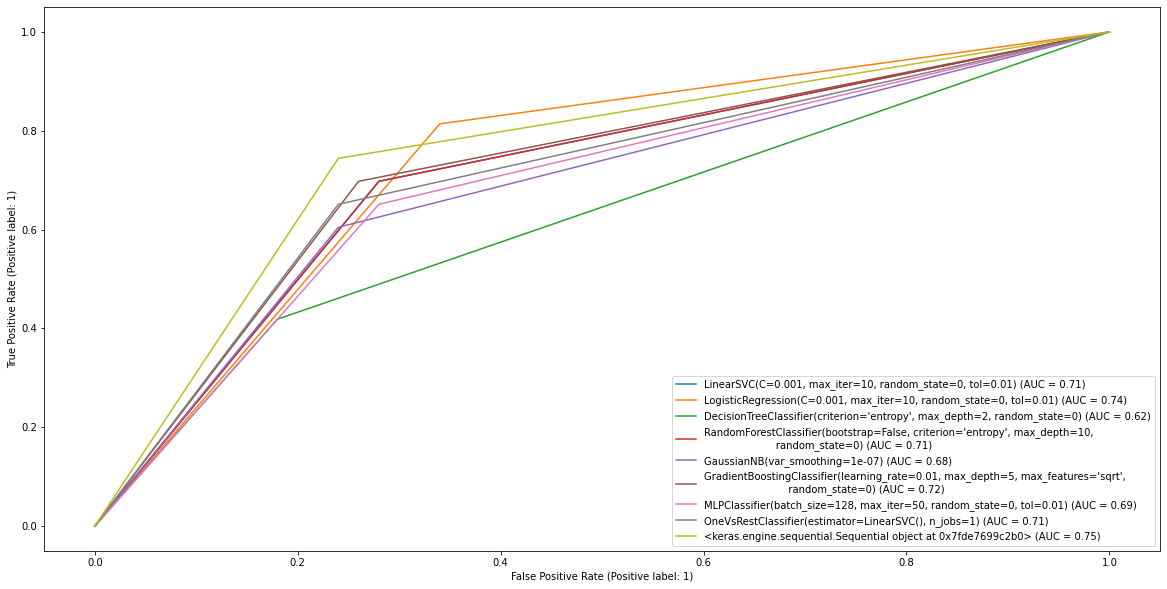

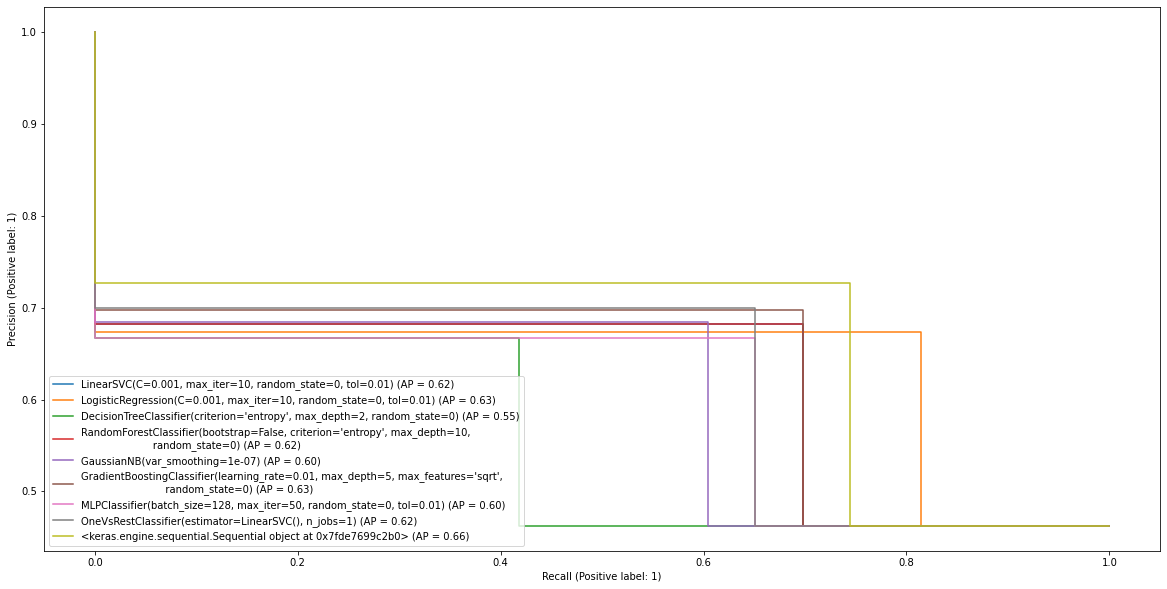

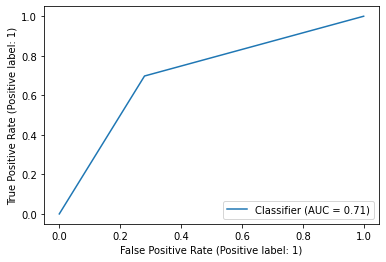

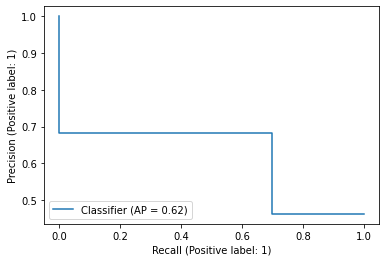

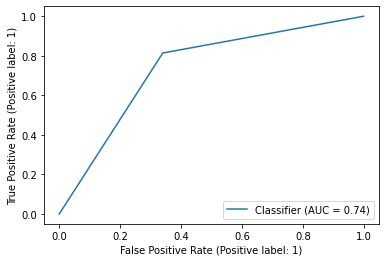

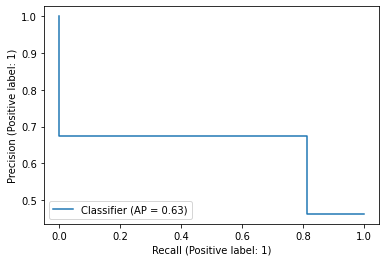

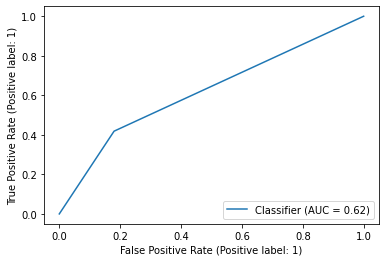

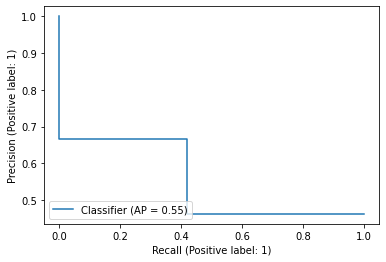

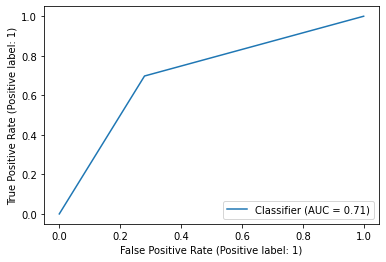

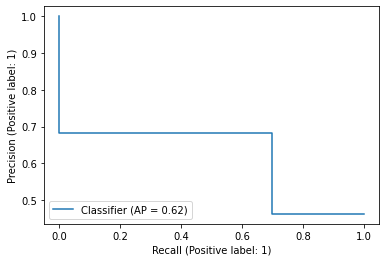

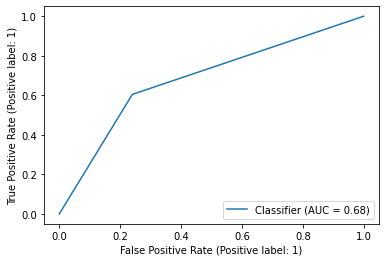

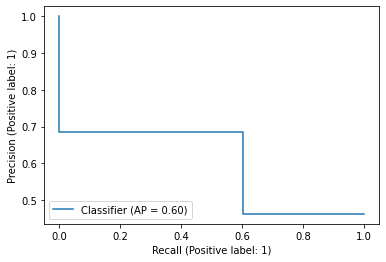

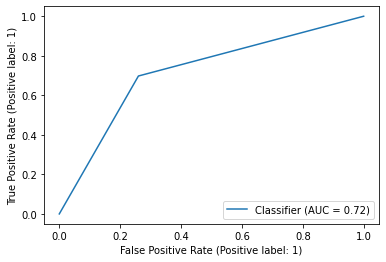

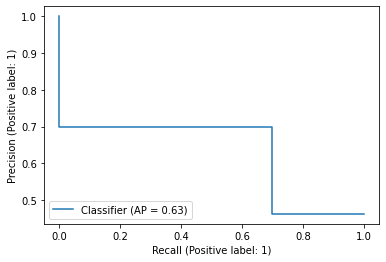

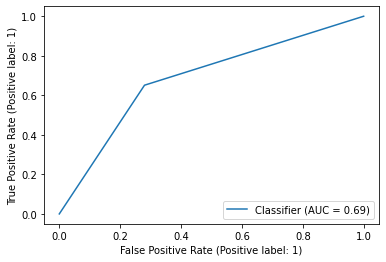

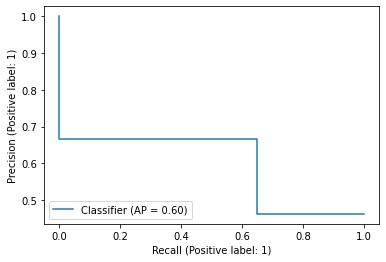

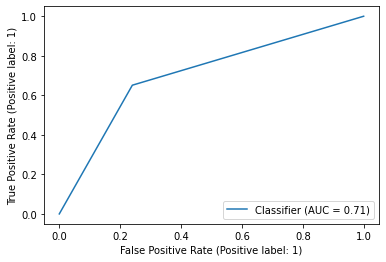

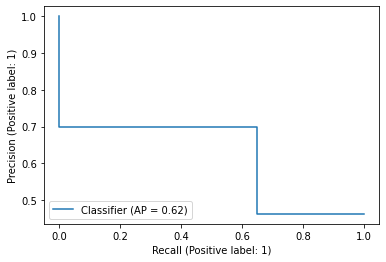

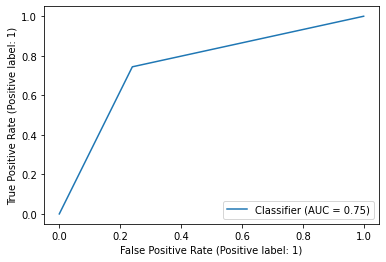

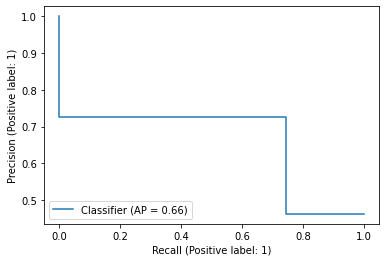

In [15]:
sklearn_accuracy = []
sklearn_confusion = []
sklearn_roc = []
sklearn_precision = []
sklearn_recall = []

_, ax = plt.subplots(figsize=(20, 10))
_, bx = plt.subplots(figsize=(20, 10))
for clf in sklearn_classifiers:
    rf_cv = GridSearchCV(estimator=clf, param_grid=grid[str(clf)[:str(clf).find("(")]], cv= 5)
    rf_cv.fit(x_train, y_train)
    clf = clf.set_params(**rf_cv.best_params_)
    clf.fit(x_train, y_train)
    if not os.path.exists("./models/diabetes/sklearn/"):
        os.makedirs("./models/diabetes/sklearn/")
    pickle.dump(clf, open("./models/diabetes/sklearn/"+str(clf)[:str(clf).find("(")]+".sav", 'wb'))
    for i, v in rf_cv.best_params_.items():
        para[str(clf)[:str(clf).find("(")]][i].append(v)
    print(str(clf)[:str(clf).find("(")], rf_cv.best_params_)
    accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, clf.predict(x_test), ax, bx)
    sklearn_accuracy.append(accuracy)
    sklearn_confusion.append(confusion)
    sklearn_roc.append(roc)
    sklearn_precision.append(precision)
    sklearn_recall.append(recall)
    
clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(1, activation='sigmoid'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=keras.metrics.BinaryAccuracy())

clf.fit(x_train, y_train, verbose=0, epochs=5)
accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, np.round(clf.predict(x_test, verbose=0))[:,0], ax, bx)
sklearn_accuracy.append(accuracy)
sklearn_confusion.append(confusion)
sklearn_roc.append(roc)
sklearn_precision.append(precision)
sklearn_recall.append(recall)


In [16]:
grid = {}
for i in para.keys():
    if i == "GaussianNB":
        grid["NaiveBayes"] = {}
        for j in para[i].values():
            grid["NaiveBayes"][j[0]] = j[1]
    elif i == "GradientBoostingClassifier":
        grid["GBTClassifier"] = {}
        for j in para[i].values():
            grid["GBTClassifier"][j[0]] = j[1]
    elif i == "MLPClassifier":
        grid["MultilayerPerceptronClassifier"] = {}
        for j in para[i].values():
            grid["MultilayerPerceptronClassifier"][j[0]] = j[1]
    elif i == "OneVsRestClassifier":
        grid["OneVsRest"] = {}
        for j in para[i].values():
            grid["OneVsRest"][j[0]] = j[1]
    else:
        grid[i] = {}
        for j in para[i].values():
            grid[i][j[0]] = j[1]

22/11/04 13:38:08 WARN DAGScheduler: Broadcasting large task binary with size 1206.2 KiB
22/11/04 13:38:09 WARN DAGScheduler: Broadcasting large task binary with size 1481.8 KiB
22/11/04 13:38:09 WARN DAGScheduler: Broadcasting large task binary with size 1719.3 KiB
22/11/04 13:38:12 WARN DAGScheduler: Broadcasting large task binary with size 1326.2 KiB


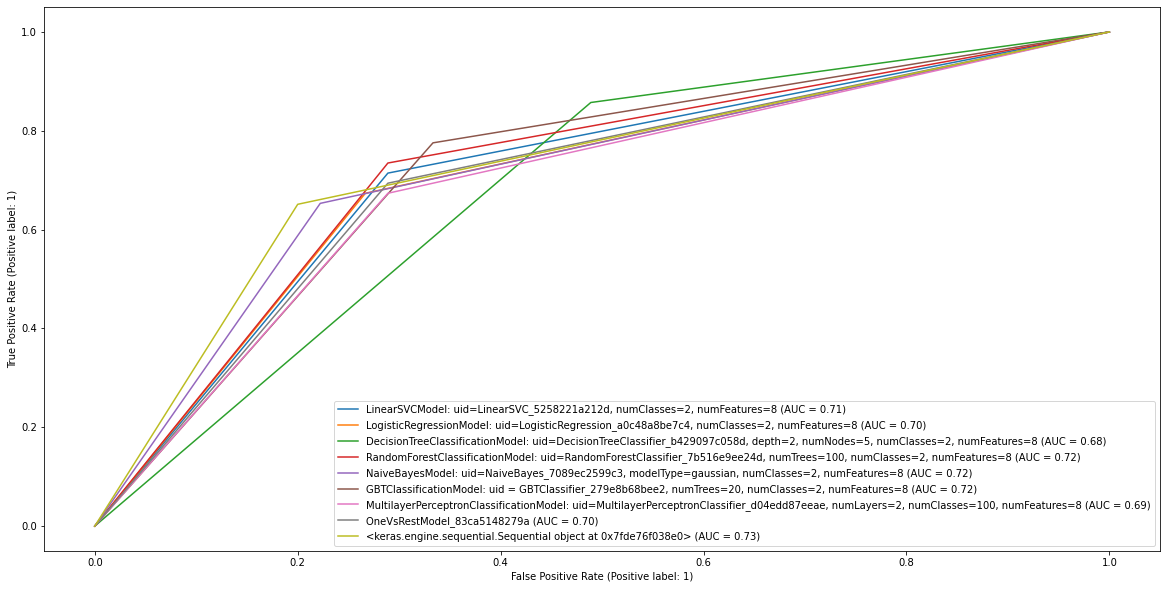

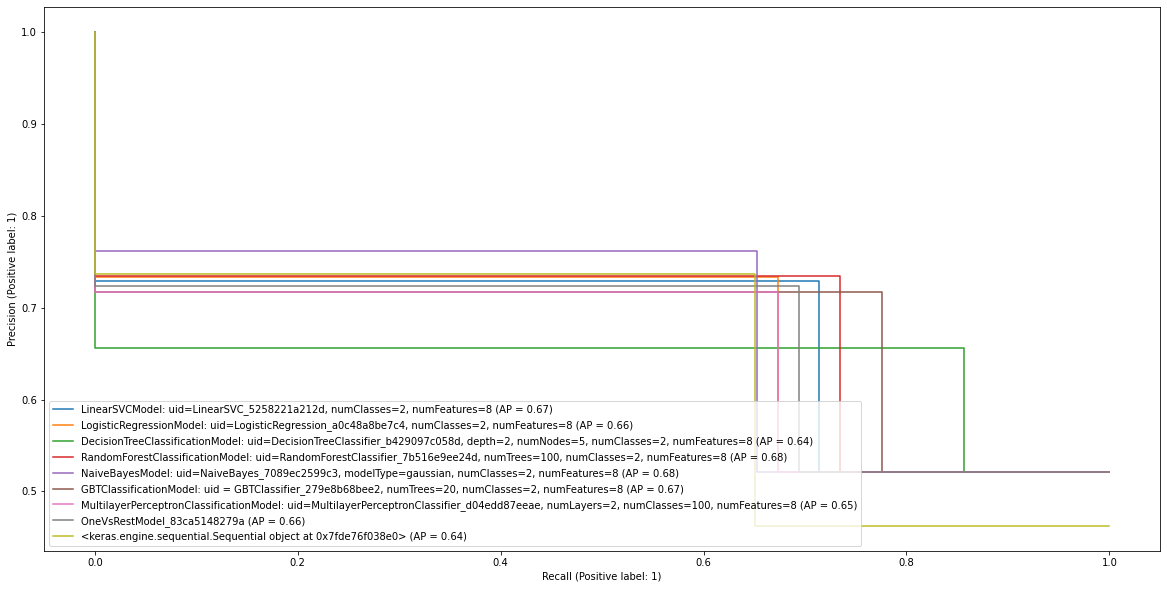

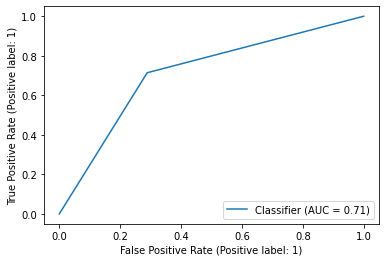

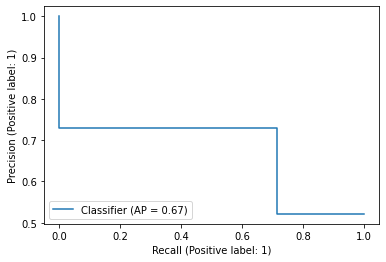

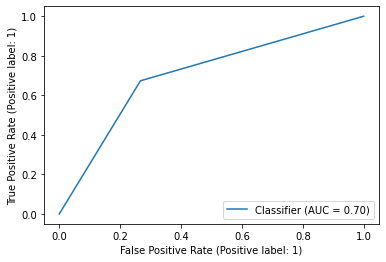

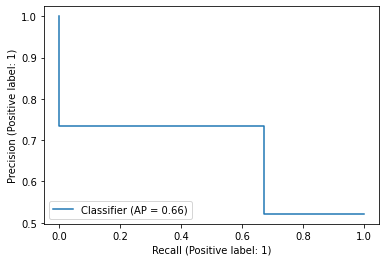

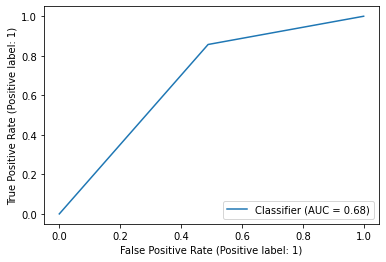

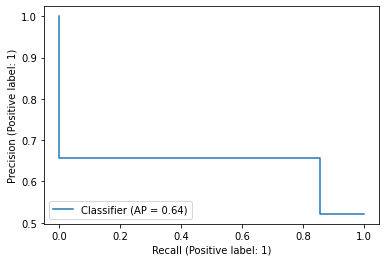

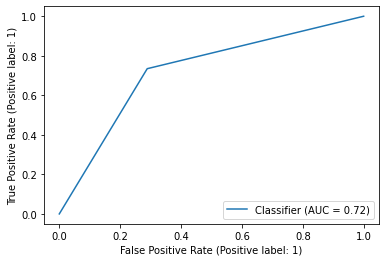

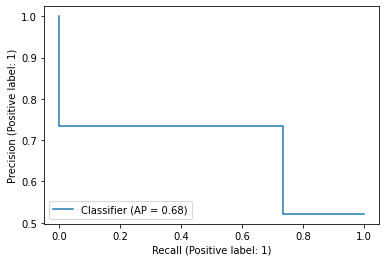

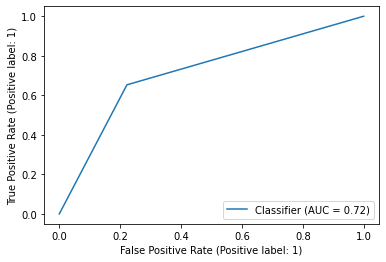

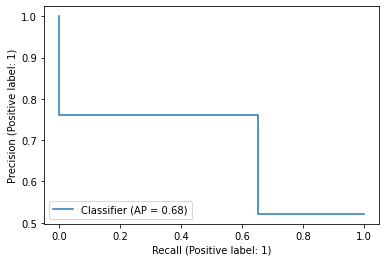

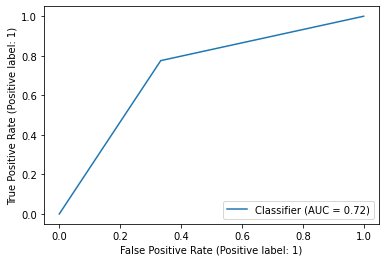

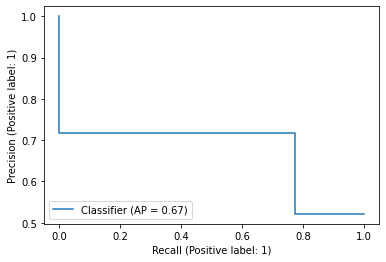

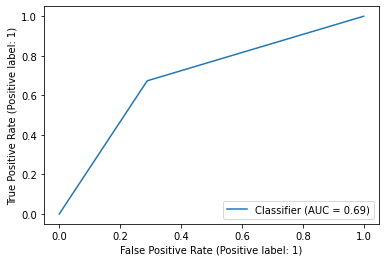

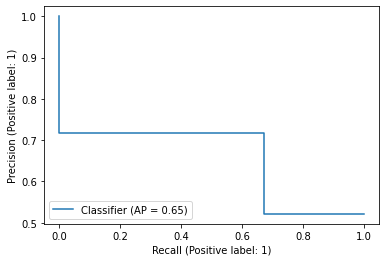

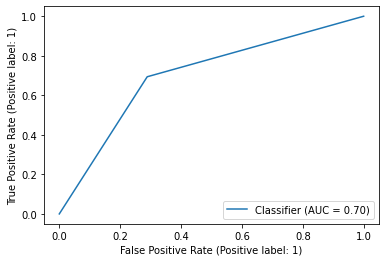

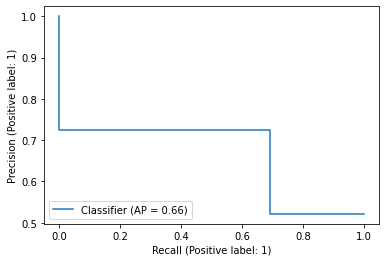

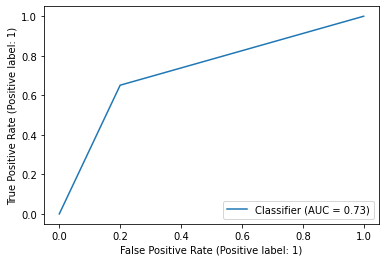

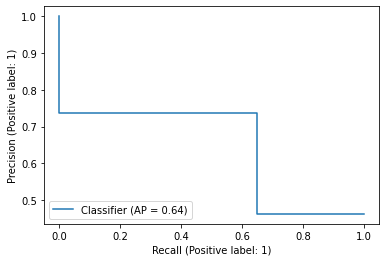

In [17]:
pyspark_accuracy = []
pyspark_confusion = []
pyspark_roc = []
pyspark_precision = []
pyspark_recall = []
_, ax = plt.subplots(figsize=(20, 10))
_, bx = plt.subplots(figsize=(20, 10))
if os.path.exists("./models/diabetes/pyspark/"):
    shutil.rmtree("./models/diabetes/pyspark/", ignore_errors=True)
for clf in pyspark_classifiers:
    clf = clf.setParams(**grid[str(clf)[:str(clf).find("_")]])
    clf = clf.fit(train)
    if not os.path.exists("./models/diabetes/pyspark/"):
        os.makedirs("./models/diabetes/pyspark/")
    clf.save("./models/diabetes/pyspark/"+str(clf)[:str(clf).find("_")])
    real = np.array([1 if "1" in str(x) else 0 for x in clf.transform(test).select("label").collect()])
    pred = np.array([1 if "1" in str(x) else 0 for x in clf.transform(test).select("prediction").collect()])
    accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, real, pred, ax, bx)
    pyspark_accuracy.append(accuracy)
    pyspark_confusion.append(confusion)
    pyspark_roc.append(roc)
    pyspark_precision.append(precision)
    pyspark_recall.append(recall)
    
clf = keras.Sequential()
clf.add(keras.layers.Dense(1024, activation='relu'))
clf.add(keras.layers.Dense(512, activation='relu'))
clf.add(keras.layers.Dense(128, activation='relu'))
clf.add(keras.layers.Dense(32, activation='relu'))
clf.add(keras.layers.Dense(1, activation='sigmoid'))

clf.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=keras.metrics.BinaryAccuracy())

clf.fit(x_train, y_train, verbose=0, epochs=5)
clf.save("./models/diabetes/keras.h5")
accuracy, confusion, roc, precision, recall = eval_methods.eval(clf, y_test, np.round(clf.predict(x_test, verbose=0))[:,0], ax, bx)
pyspark_accuracy.append(accuracy)
pyspark_confusion.append(confusion)
pyspark_roc.append(roc)
pyspark_precision.append(precision)
pyspark_recall.append(recall)

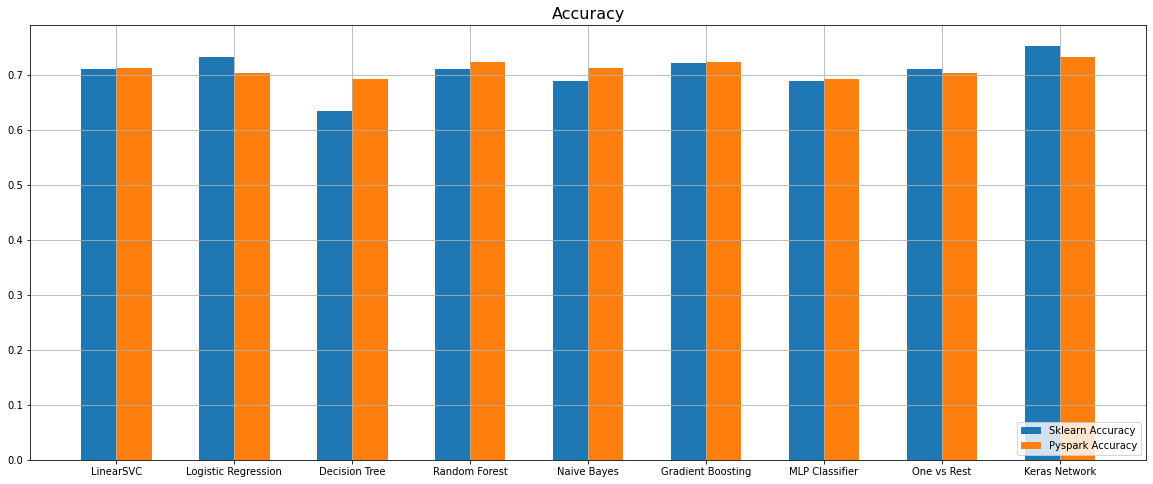

In [18]:
eval_methods.plot(sklearn_accuracy, pyspark_accuracy, "Accuracy")

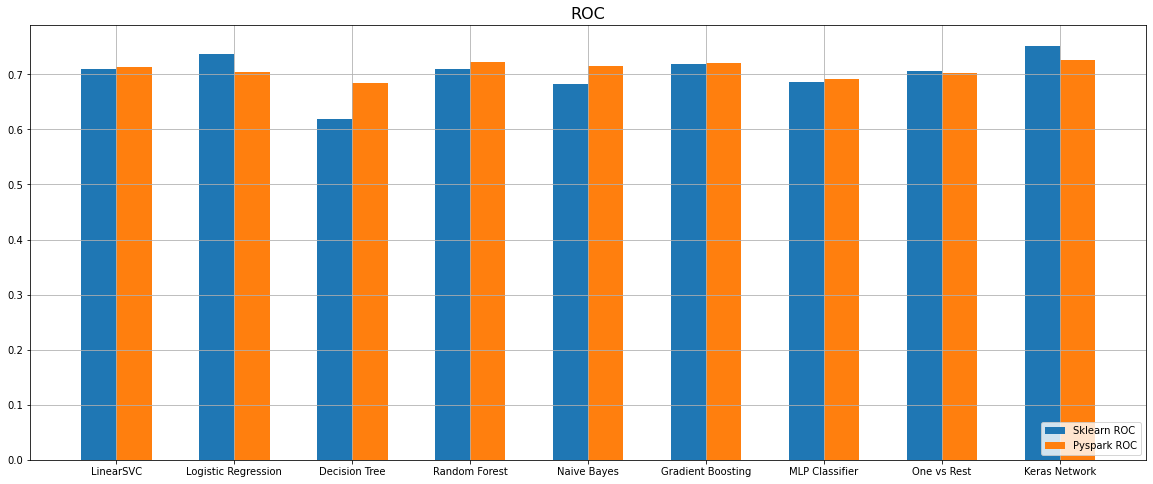

In [19]:
eval_methods.plot(sklearn_roc, pyspark_roc, "ROC")

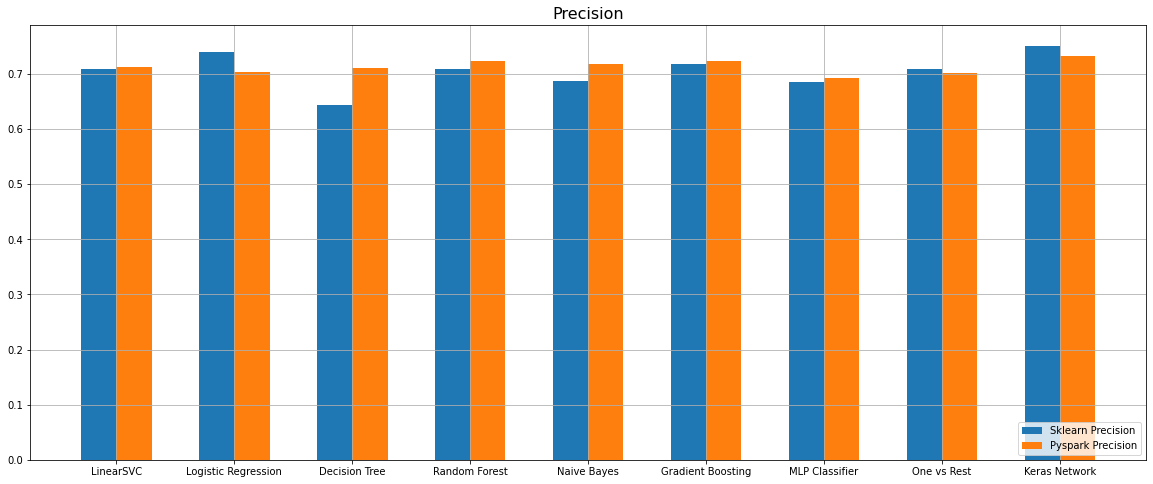

In [20]:
eval_methods.plot(sklearn_precision, pyspark_precision, "Precision")

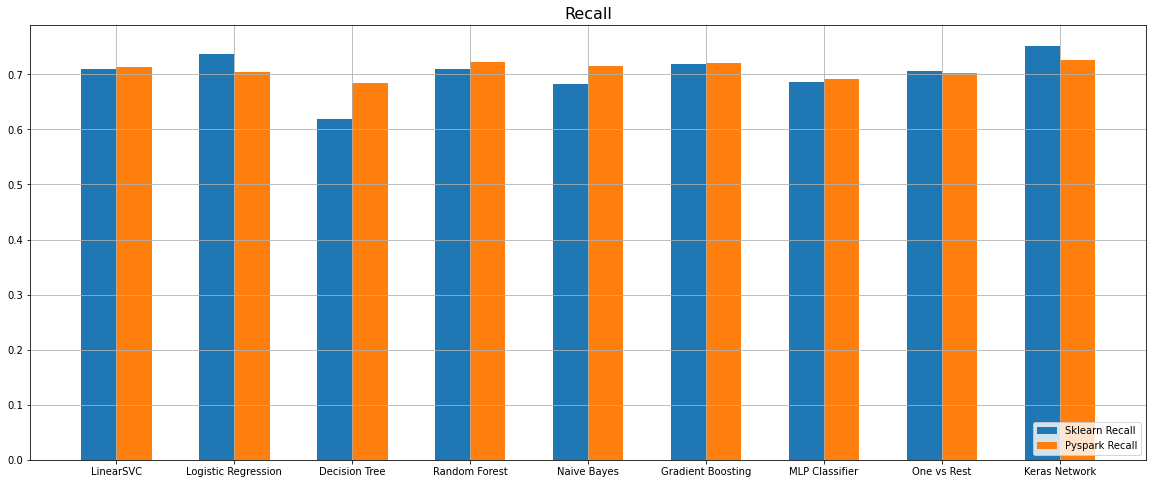

In [21]:
eval_methods.plot(sklearn_recall, pyspark_recall, "Recall")

                ============ End =====================